In [1]:
# todo: check the model cfg: augmentations, policy

In [2]:
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm as colormap


import torch
from torch import nn
from utils import parse_cfg, iou_vectorized, objectness_filter_and_nms, show_predictions, scale_numbers, letterbox_pad, get_corner_coords
from darknet import Darknet

In [3]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')
weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
darknet.eval();

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms


(452, 602, 3)


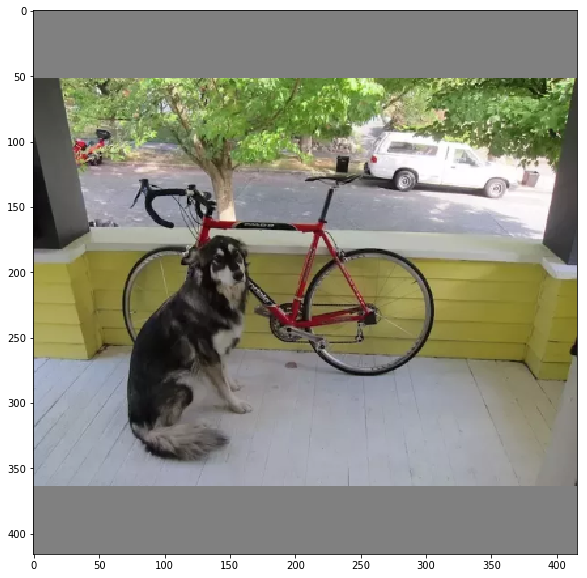

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


make bboxes on image more pleasant


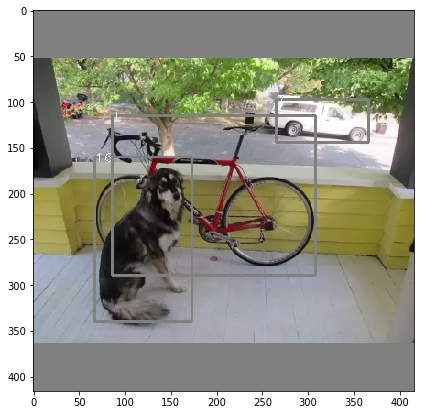

In [4]:
classes = 80
net_input_size = int(darknet.net_info['width'])
device = torch.device('cpu:0')

plt.figure(figsize=(10, 10))
img_path = 'dog-cycle-car.png'
# img_path = 'people_outside.jpg'
# img_path = 'city_hall.jpg'
img = cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W, C = img.shape
H_new, W_new, scale = scale_numbers(H, W, net_input_size)
img = cv2.resize(img, (W_new, H_new))
img, _ = letterbox_pad(img, net_input_size, color=(128, 128, 128))
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
img = img / 255
pred = darknet(img, device)
pred = objectness_filter_and_nms(pred, classes)
show_predictions('dog-cycle-car.png', pred, classes, net_input_size)

In [5]:
# todo show_predictions(): b) bboxes colors and labels

In [11]:
image_path = 'dog-cycle-car.png'
save_path = 'output.jpg'
labels_path = 'data/coco.names'
model = darknet
device = torch.device('cpu:0')
show=True

In [7]:
def predict_and_save(image_path, save_path, model, device, labels_path='./data/coco.names', show=False):
    # make sure the arguments are of correct types
    assert isinstance(image_path, str), '"image_path" should be str'
    assert isinstance(save_path, (NoneType, str)), 'save_path should be NoneType or str'
    assert isinstance(labels_path, str), '"labels_path" should be str'
    assert isinstance(model, Darknet), 'model should be a Darknet module'
    assert isinstance(device, (torch.device, str)), 'device should be either torch.device or str'
    assert isinstance(show, bool), 'show should be boolean'
    
    # todo but first  b) bboxes labels

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


make bboxes on image more pleasant


True

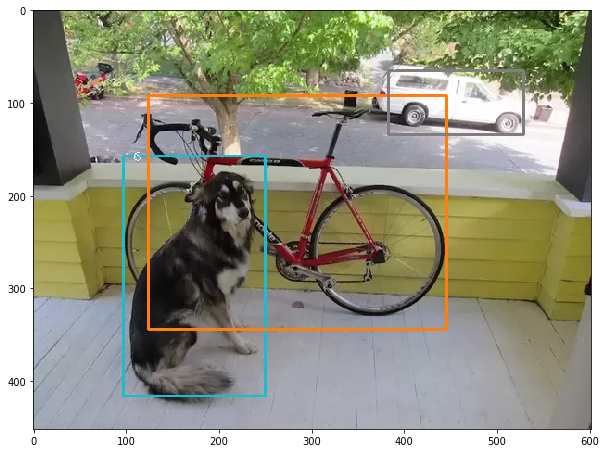

In [15]:
# make a dict: {class_number: class_name}
names = [name.replace('\n', '') for name in open(labels_path, 'r').readlines()]
num2name = {num: name for num, name in enumerate(names)}

# parameters of the vizualization (color palette and figure size to display)
norm = Normalize(vmin=0, vmax=classes)
color_map = colormap.tab10
figsize = (10, 10)

# read an image and transform the colors from BGR to RGB
img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, net_input_size)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img, net_input_size, color=(128, 128, 128))

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

# make prediction and apply objectness filtering and nms
predictions = darknet(img, device)
predictions = objectness_filter_and_nms(predictions, classes)

# since the predictions are made for a resized and padded images, 
# the bounding boxes have to be scaled and shifted back
# for that, we shift and scale back the bboxes' attributes
pad_top, pad_bottom, pad_left, pad_right = pad_sizes
predictions[:, 0] = (predictions[:, 0] - pad_left) / scale
predictions[:, 1] = (predictions[:, 1] - pad_top) / scale
predictions[:, 2] = predictions[:, 2] / scale
predictions[:, 3] = predictions[:, 3] / scale

# the, transform the coordinates (cx, cy, w, h) into corner coordinates: 
# (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
top_left_x, top_left_y, bottom_right_x, bottom_right_y = get_corner_coords(predictions)

# detach values from the computation graph, take the int part and transform to np.ndarray
top_left_x = top_left_x.detach().int().numpy()
top_left_y = top_left_y.detach().int().numpy()
bottom_right_x = bottom_right_x.detach().int().numpy()
bottom_right_y = bottom_right_y.detach().int().numpy()

if show:
    plt.figure(figsize=figsize)
    
print('make bboxes on image more pleasant')

# add each prediction on the image and captures it with a class number
for i in range(len(predictions)):
    ## ADD BBOXES
    # we need to scale and shift corner coordinates because we used the letterbox padding
    top_left_coords = (top_left_x[i], top_left_y[i])
    bottom_right_coords = (bottom_right_x[i], bottom_right_y[i])
    # predicted class number and corresponding name
    class_int = int(predictions[i, 6].detach().numpy())
    # select the color for a class according to its label number and scale it to [0, 255]
    bbox_color = color_map(class_int)[:3]
    bbox_color = list(map(lambda x: x * 255, bbox_color))
    

    # add a bbox
    cv2.rectangle(img_raw, top_left_coords, bottom_right_coords, bbox_color, 2)
    
    ## ADD A LABLE FOR EACH BBOX
    class_name = num2name[class_int]
    # adds the class number
    cv2.putText(img_raw, str(class_int), (top_left_x[i], top_left_y[i] + 2 + 4), 
                cv2.FONT_HERSHEY_PLAIN, 1, [225, 255, 255], 1)

if show:
    plt.imshow(img_raw)
    
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_path, img_raw, [int(cv2.IMWRITE_JPEG_QUALITY), 80])